In [13]:
%env

import torch
import os
import copy
from conch.open_clip_custom import create_model_from_pretrained
import pandas as pd
from PIL import Image
from tqdm import tqdm
import numpy as np
from sklearn.linear_model import Ridge

# Set up the configuration
local_weights = False
model_cfg = 'conch_ViT-B-16'

if local_weights:
    checkpoint_path = './checkpoints/CONCH/pytorch_model.bin'
else:
    from dotenv import load_dotenv
    load_dotenv()  # take environment variables from .env.
    checkpoint_path = 'hf_hub:MahmoodLab/conch'
    hf_auth_token = os.getenv("HF_AUTH_TOKEN")
    if hf_auth_token is None:
        raise ValueError("HF_AUTH_TOKEN environment variable not set")

# Load the model
model, preprocess = create_model_from_pretrained(model_cfg, checkpoint_path, hf_auth_token=hf_auth_token)
model_vit = model.visual

# Move the model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_vit.to(device)

# Print the model to verify
#print(model_vit)

/home/hu-eki/Projects/CONCH/conch/open_clip_custom/factory.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=map_loc

VisualModel(
  (trunk): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')


In [19]:
# Settings
base_folder = '/home/hu-eki/Data/BCNB'
ids_file = os.path.join(base_folder, "patient-clinical-data.xlsx")
data_folder = os.path.join(base_folder, "paper_patches", "patches")
output_folder = os.path.join(base_folder, "embeddings")
batch_size = 16

checkpoints = {
    'model_vit_50_preprocess.pth',
    'model_vit_base_id_1.pth',
    'model_vit_50_normalized.pth',
    'model_vit_50.pth',
    
    #*(ckpt for ckpt in os.listdir(base_folder) if ckpt.endswith('.pth'))
}

In [22]:
# Function to extract embeddings for multiple models
def extract_embeddings(base_model, preprocess, state_dict_paths, ids_file, data_folder, output_folder, batch_size):
    # Load the IDs and target values
    patient_data_df = pd.read_excel(ids_file)
    ids = patient_data_df['Patient ID'].tolist()
    target_columns = ['ER', 'PR', 'HER2']
    target_values = patient_data_df.set_index('Patient ID')[target_columns].to_dict('index')

    os.makedirs(output_folder, exist_ok=True)
    
    for ckpt_path in state_dict_paths:
        model_name = os.path.splitext(os.path.basename(ckpt_path))[0]

        # Skip if the CSV file already exists
        csv_path = os.path.join(output_folder, f'{model_name}.csv')
        if os.path.exists(csv_path):
            tqdm.write(f"{csv_path} already exists. Skipping.")
            continue

        cloned_model = copy.deepcopy(base_model)
        cloned_model.load_state_dict(torch.load(ckpt_path))
        cloned_model.to(device)

        all_patients_embeddings = []

        for patient_id in tqdm(ids, desc=f'Processing {model_name}'):
            patient_folder = os.path.join(data_folder, str(patient_id))
            if not os.path.exists(patient_folder):
                tqdm.write(f"Warning: Patient folder {patient_folder} does not exist.")
                continue

            images = [f for f in os.listdir(patient_folder) if f.endswith('.jpg')]
            embeddings = []

            for i in range(0, len(images), batch_size):
                batch_images = images[i:i + batch_size]
                loaded_batch = [Image.open(os.path.join(patient_folder, image_file)).convert('RGB') for image_file in batch_images]
                input_tensors = torch.stack([preprocess(img) for img in loaded_batch]).to(device)
                # print(input_tensors.shape)

                with torch.no_grad():
                    output, _ = cloned_model(input_tensors) # Ask Karin about the output
                    # print(len(output))
                    # print(output[1].shape)
                    # print(output[0].shape)
                    embeddings.append(output.cpu())

            embeddings = torch.cat(embeddings, dim=0)
            mean_embedding = embeddings.mean(dim=0)
            df = pd.DataFrame([mean_embedding.numpy()])
            df.insert(0, 'patient_id', patient_id)
            # Add target values to the DataFrame
            for target in target_columns:
                df[target] = target_values[patient_id][target]
            all_patients_embeddings.append(df)

        final_df = pd.concat(all_patients_embeddings, ignore_index=True)
        final_df.to_csv(csv_path, index=False)

    return final_df

final_df = extract_embeddings(model_vit, preprocess, checkpoints, ids_file, data_folder, output_folder, batch_size)


/home/hu-eki/Data/BCNB/embeddings/model_vit_base_id_1.csv already exists. Skipping.
/home/hu-eki/Data/BCNB/embeddings/model_vit_50_normalized.csv already exists. Skipping.
/home/hu-eki/Data/BCNB/embeddings/model_vit_50_preprocess.csv already exists. Skipping.


/tmp/ipykernel_2146567/4266638707.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cloned_model.load_state_dict(torch.load(ckpt_path))
Processing model_vit_50: 100%|████

In [23]:
final_df

,patient_id,0,1,2,3,4,5,6,7,8,...,505,506,507,508,509,510,511,ER,PR,HER2
0,1,1.349662,-0.861701,0.166182,0.390714,-0.284235,-0.206471,-2.270187,-0.986733,-0.164217,...,1.045736,-1.317317,-0.308675,0.893192,-0.722884,-0.367156,-1.439909,Positive,Positive,Negative
1,2,1.162834,-1.163366,0.013496,1.941442,-0.828398,0.524736,-2.573299,-1.189577,0.808158,...,1.466431,-0.343535,0.173517,0.232830,-0.608981,-1.946768,-1.706830,Negative,Negative,Negative
2,3,1.499667,-1.638863,1.239933,1.459166,-0.395105,-0.047343,-1.822767,-0.611576,0.532959,...,-0.743347,-0.293447,1.196439,0.784914,-0.290053,-0.816259,-1.582323,Positive,Positive,Negative
3,4,0.747543,-0.782031,1.421764,1.537230,-1.463286,0.308843,-1.730947,-0.736905,0.338508,...,0.281312,0.944758,0.970192,0.597468,-0.814879,-1.836784,-1.352637,Negative,Negative,Positive
4,5,0.925897,-0.585046,-0.177389,0.652480,-0.660803,-0.459097,-2.079312,-0.925243,0.082780,...,1.693365,-1.062010,-0.870500,0.551714,-1.155259,-1.471032,-1.163244,Negative,Negative,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1053,1054,1.019827,-1.024783,0.072706,-0.208488,-0.150433,-0.530485,-1.990971,-1.459942,-0.216113,...,0.760245,-1.083846,-0.637802,0.843171,-0.443738,-1.109451,-1.567150,Positive,Positive,Positive
1054,1055,1.527233,-1.287080,0.301716,0.873804,-0.531230,-0.153845,-2.401216,-1.265526,0.851441,...,0.596305,-0.890067,-0.082974,0.797997,-0.143005,-0.792162,-1.208558,Positive,Positive,Negative
1055,1056,1.048387,-1.177324,0.884545,1.849551,-0.962189,0.820971,-2.577111,-0.923722,1.359922,...,0.547040,-0.006479,0.709447,0.849985,-0.137114,-1.433697,-1.104869,Positive,Positive,Positive
1056,1057,1.222563,-1.185011,1.880377,2.614251,-1.676340,0.790138,-2.174931,-0.542509,0.628379,...,-0.505815,0.577158,1.191100,0.273128,-0.299107,-1.314673,-0.747442,Positive,Positive,Negative


In [37]:
import numpy as np
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import roc_auc_score, balanced_accuracy_score

# Load the data from the saved .csv files
def load_embeddings(output_folder, checkpoint_names):
    embeddings = {}
    for ckpt_name in checkpoint_names:
        model_name = os.path.splitext(os.path.basename(ckpt_name))[0]
        csv_path = os.path.join(output_folder, f'{model_name}.csv')
        embeddings[model_name] = pd.read_csv(csv_path)
    return embeddings

# Train and test a ridge regressor
def train_and_test_ridge(embeddings, train_indices, test_indices, random_state=42, max_iter=1000):
    results = {}
    for model_name, df in embeddings.items():
        X = df.drop(columns=['patient_id', 'ER', 'PR', 'HER2']).values
        y = df[['ER', 'PR', 'HER2']].map(lambda x: 1 if x == 'Positive' else 0).values

        X_train = df[df['patient_id'].isin(train_indices)].drop(columns=['patient_id', 'ER', 'PR', 'HER2']).values
        X_test = df[df['patient_id'].isin(test_indices)].drop(columns=['patient_id', 'ER', 'PR', 'HER2']).values
        y_train = y[df['patient_id'].isin(train_indices)]
        y_test = y[df['patient_id'].isin(test_indices)]

        print(f"Using LogisticRegression for model {model_name}")

        preds_all = np.zeros_like(y_test, dtype=float)
        for i in range(y_train.shape[1]):
            clf = LogisticRegression(random_state=random_state, max_iter=max_iter)
            clf.fit(X_train, y_train[:, i])
            preds_all[:, i] = clf.predict_proba(X_test)[:, 1]

        preds_bin = (preds_all > 0.5).astype(int)
        accuracies = (preds_bin == y_test).mean(axis=0)
        print(f"Accuracy for {model_name}: ER={accuracies[0]:.3f}, PR={accuracies[1]:.3f}, HER2={accuracies[2]:.3f}")

        # Compute and store predictions and basic accuracies
        aucs = [roc_auc_score(y_test[:, i], preds_all[:, i]) for i in range(y_test.shape[1])]
        bal_accs = [balanced_accuracy_score(y_test[:, i], preds_bin[:, i]) for i in range(y_test.shape[1])]

        results[model_name] = {
            'seed': random_state,
            'predictions': preds_all,
            'accuracies': {'ER': accuracies[0], 'PR': accuracies[1], 'HER2': accuracies[2]},
            'auc': {'ER': aucs[0], 'PR': aucs[1], 'HER2': aucs[2]},
            'balanced_accuracy': {'ER': bal_accs[0], 'PR': bal_accs[1], 'HER2': bal_accs[2]}
        }
    return results

def train_and_test_ridge_multi(embeddings, train_indices, test_indices, max_iter=1000, n_classifiers=100):
    results = []
    for seed in tqdm(range(n_classifiers), desc="Training classifiers"):
        for model_name, df in embeddings.items():
            X = df.drop(columns=['patient_id', 'ER', 'PR', 'HER2']).values
            y = df[['ER', 'PR', 'HER2']].map(lambda x: 1 if x == 'Positive' else 0).values

            X_train = df[df['patient_id'].isin(train_indices)].drop(columns=['patient_id', 'ER', 'PR', 'HER2']).values
            X_test = df[df['patient_id'].isin(test_indices)].drop(columns=['patient_id', 'ER', 'PR', 'HER2']).values
            y_train = y[df['patient_id'].isin(train_indices)]
            y_test = y[df['patient_id'].isin(test_indices)]

            preds_all = np.zeros_like(y_test, dtype=float)
            for i in range(y_train.shape[1]):
                clf = LogisticRegression(random_state=seed, max_iter=max_iter)
                clf.fit(X_train, y_train[:, i])
                preds_all[:, i] = clf.predict_proba(X_test)[:, 1]

            preds_bin = (preds_all > 0.5).astype(int)
            accuracies = (preds_bin == y_test).mean(axis=0)
            aucs = [roc_auc_score(y_test[:, i], preds_all[:, i]) for i in range(y_test.shape[1])]
            bal_accs = [balanced_accuracy_score(y_test[:, i], preds_bin[:, i]) for i in range(y_test.shape[1])]

            results.append({
                'model_name': model_name,
                'seed': seed,
                'predictions': preds_all,
                'accuracies': {'ER': accuracies[0], 'PR': accuracies[1], 'HER2': accuracies[2]},
                'auc': {'ER': aucs[0], 'PR': aucs[1], 'HER2': aucs[2]},
                'balanced_accuracy': {'ER': bal_accs[0], 'PR': bal_accs[1], 'HER2': bal_accs[2]}
            })
    return results


# Settings
splitting_folder = os.path.join(base_folder, "dataset-splitting")
checkpoint_names = [
    'model_vit_50_preprocess.pth',
    'model_vit_base_id_1.pth',
    'model_vit_50_normalized.pth',
    'model_vit_50.pth',
]


embeddings = load_embeddings(output_folder, checkpoint_names)
# Load train and test indices from files
train_indices = np.loadtxt(os.path.join(splitting_folder, 'train_id.txt'), dtype=int).tolist()
test_indices = np.loadtxt(os.path.join(splitting_folder, 'test_id.txt'), dtype=int).tolist()
results = train_and_test_ridge_multi(embeddings, train_indices, test_indices, n_classifiers=1000)

Training classifiers: 100%|██████████| 1000/1000 [10:34<00:00,  1.58it/s]


,Model,Metric,ER,PR,HER2
0,model_vit_50,accuracies,0.816514,0.756881,0.724771
1,model_vit_50,auc,0.845690,0.796074,0.745253
2,model_vit_50,balanced_accuracy,0.714435,0.665814,0.562025
3,model_vit_50_normalized,accuracies,0.830275,0.793578,0.743119
4,model_vit_50_normalized,auc,0.850093,0.813407,0.776055
5,model_vit_50_normalized,balanced_accuracy,0.716867,0.716352,0.590190
6,model_vit_50_preprocess,accuracies,0.848624,0.816514,0.715596
7,model_vit_50_preprocess,auc,0.870366,0.828965,0.741245
8,model_vit_50_preprocess,balanced_accuracy,0.748726,0.737287,0.560865
9,model_vit_base_id_1,accuracies,0.839450,0.798165,0.761468


                         Model  Seed             Metric Marker     Score
0      model_vit_50_preprocess     0         accuracies     ER  0.848624
1      model_vit_50_preprocess     0                auc     ER  0.870366
2      model_vit_50_preprocess     0  balanced_accuracy     ER  0.748726
3          model_vit_base_id_1     0         accuracies     ER  0.839450
4          model_vit_base_id_1     0                auc     ER  0.886237
...                        ...   ...                ...    ...       ...
35995  model_vit_50_normalized   999                auc   HER2  0.776055
35996  model_vit_50_normalized   999  balanced_accuracy   HER2  0.590190
35997             model_vit_50   999         accuracies   HER2  0.724771
35998             model_vit_50   999                auc   HER2  0.745253
35999             model_vit_50   999  balanced_accuracy   HER2  0.562025

[36000 rows x 5 columns]


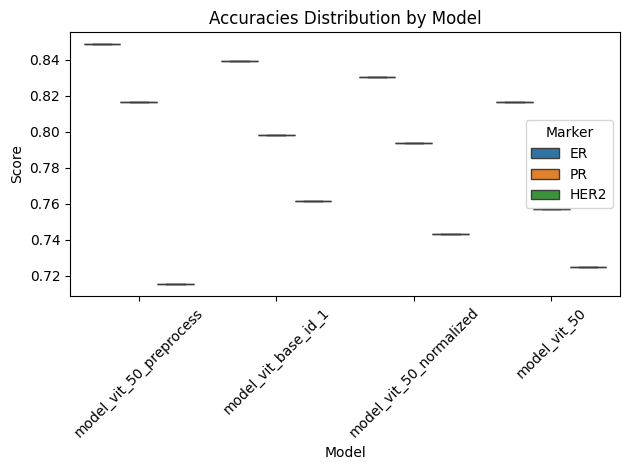

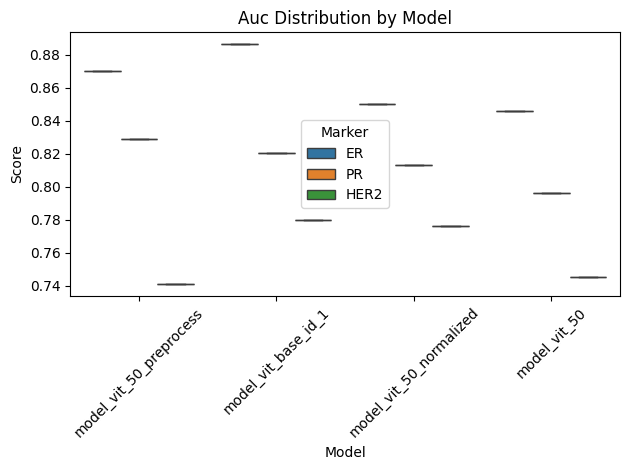

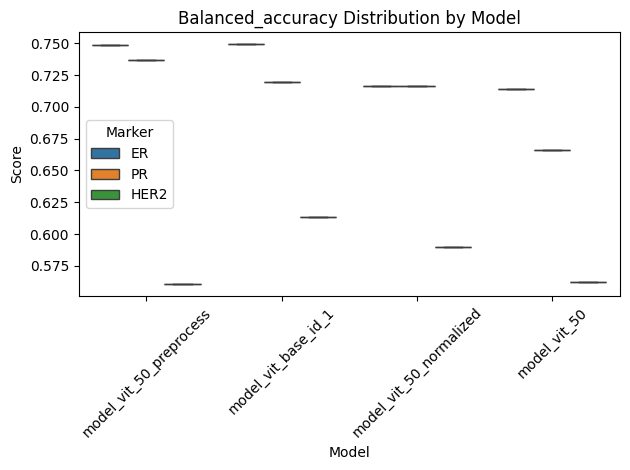

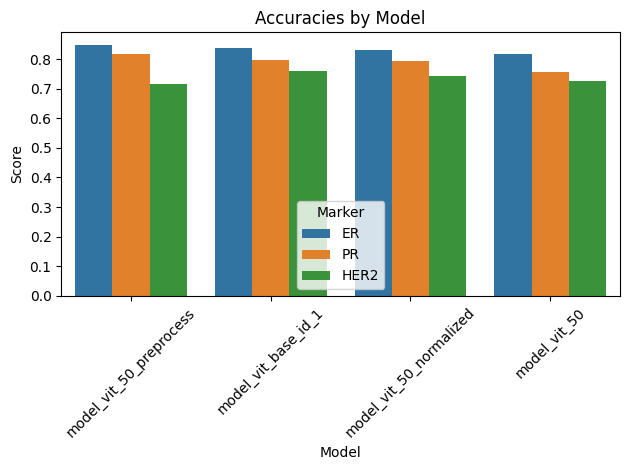

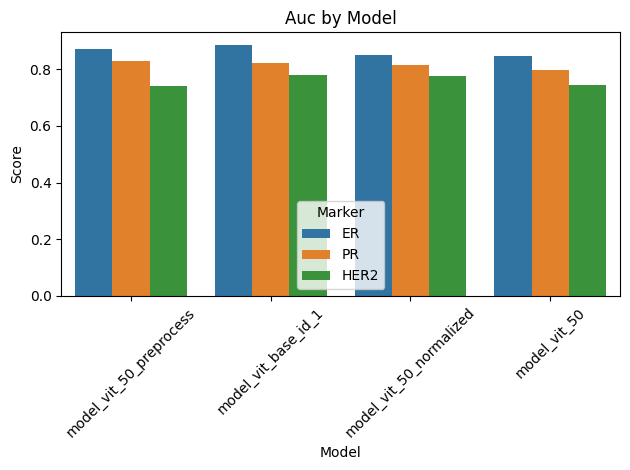

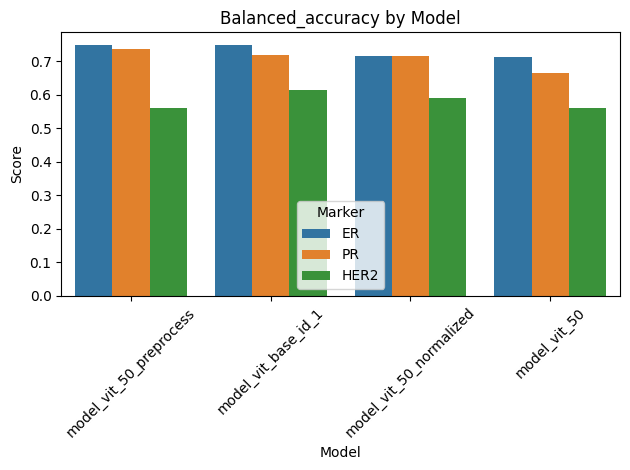

In [62]:
import os
import seaborn as sns
output_file = os.path.join(output_folder, 'results_summary_multi.csv')
rows = []
for metrics in results:
    for metric_type in ['accuracies', 'auc', 'balanced_accuracy']:
        row = {
            'Model': metrics['model_name'],
            'Seed': metrics['seed'],
            'Metric': metric_type,
            'ER': metrics[metric_type]['ER'],
            'PR': metrics[metric_type]['PR'],
            'HER2': metrics[metric_type]['HER2']
        }
        rows.append(row)

df_results = pd.DataFrame(rows)
write_header = not os.path.exists(output_file)
df_results.to_csv(output_file, index=False, mode='a', header=write_header)

df_results
import matplotlib.pyplot as plt

# Compute average metrics per model
agg_metrics = df_results.groupby(['Model', 'Metric'])[['ER', 'PR', 'HER2']].mean().reset_index()
display(agg_metrics)

# Melt data for box plots
df_melted = df_results.melt(
    id_vars=['Model', 'Seed', 'Metric'],
    value_vars=['ER', 'PR', 'HER2'],
    var_name='Marker',
    value_name='Score'
)

print(df_melted)

# Separate plots by metric so it's clear what is accuracy, AUC, or balanced accuracy
for metric in df_melted['Metric'].unique():
    subset = df_melted[df_melted['Metric'] == metric]
    sns.boxplot(data=subset, x='Model', y='Score', hue='Marker', whis=[1, 99])
    plt.title(f"{metric.capitalize()} Distribution by Model")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Optionally, create a bar plot for each metric
for metric in df_melted['Metric'].unique():
    subset = df_melted[df_melted['Metric'] == metric]
    sns.barplot(data=subset, x='Model', y='Score', hue='Marker', errorbar=('ci', 99))
    plt.title(f"{metric.capitalize()} by Model")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
